

# Vectorized BackTesting

### Content

* Sortino Beta Alpha
* Drawdown 
* Create function BackTest to evaluate the strategy in the later sections



### Environnement

In [3]:
!pip install yfinance    

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from matplotlib import cycler

colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rc('figure', facecolor='#313233')

# Section 1: Sortino Beta Alpha

###### Sortino

<p align="center">
$Sortino = \frac{\mu }{\sigma_{down}}$



In [9]:
# Prepare the datas 
f = yf.download("GOOG", end="2021-01-01")
return_serie = f["Close"].pct_change(1).dropna()
return_serie.name = "return"

# Compute the sortino
mean = np.mean(return_serie) #252
vol = np.std(return_serie[return_serie<0]) #sqrt(252)
sortino = np.sqrt(252) * mean/vol

print(f"Sortino: {'%.3f' % sortino}")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Sortino: 1.232


###### Beta



In [12]:
# We need compute the covariance between the marlet and the portfolio 
sp500 = yf.download("^GSPC")["Close"].pct_change(1)
sp500.name = "SP500"

# We concate them to do the covariances
val = pd.concat((return_serie, sp500), axis=1).dropna()

# We compute beta 
cov_var_mat = np.cov(val.values, rowvar=False)
cov = cov_var_mat[0][1]
var = cov_var_mat[1][1]

beta = cov/var

print(f"Beta: {'%.3f' % beta}")

[*********************100%***********************]  1 of 1 completed

Beta: 0.965


###### **Alpha**



In [15]:
# We compute alpha 
alpha = (252 * mean * (1-beta))*100
print(f"Alpha: {'%.1f' % alpha}")

Alpha: 0.9


# Section 2: Drawdown


In [18]:
def drawdown_function(serie):

  # We compute Cumsum of the returns
  cum = serie.dropna().cumsum() + 1

  # We compute max of the cumsum on the period (accumulate max) # (1,3,5,3,1) --> (1,3,5,5,5)
  running_max = np.maximum.accumulate(cum)

  # We compute drawdown
  drawdown = cum/running_max - 1
  return drawdown

ValueError: 'y1' is not 1-dimensional

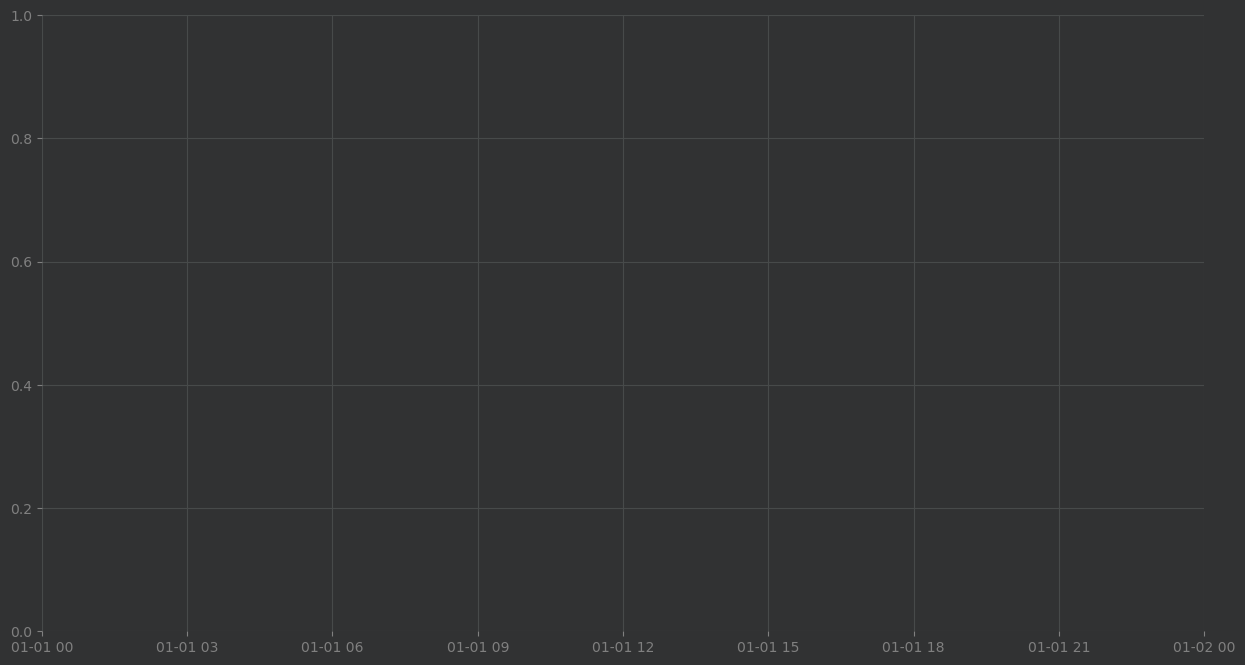

In [20]:
# We compute drawdown
drawdown = drawdown_function(return_serie)

# Adapt figure size
plt.figure(figsize=(15,8))

# Plot the drawdown
plt.fill_between(drawdown.index, drawdown*100, 0,
                 drawdown, color="#CE5757", alpha=0.65)

# Put a title
plt.title("Drawdown")

# Put y label
plt.ylabel("Drawdown in %")

plt.show()


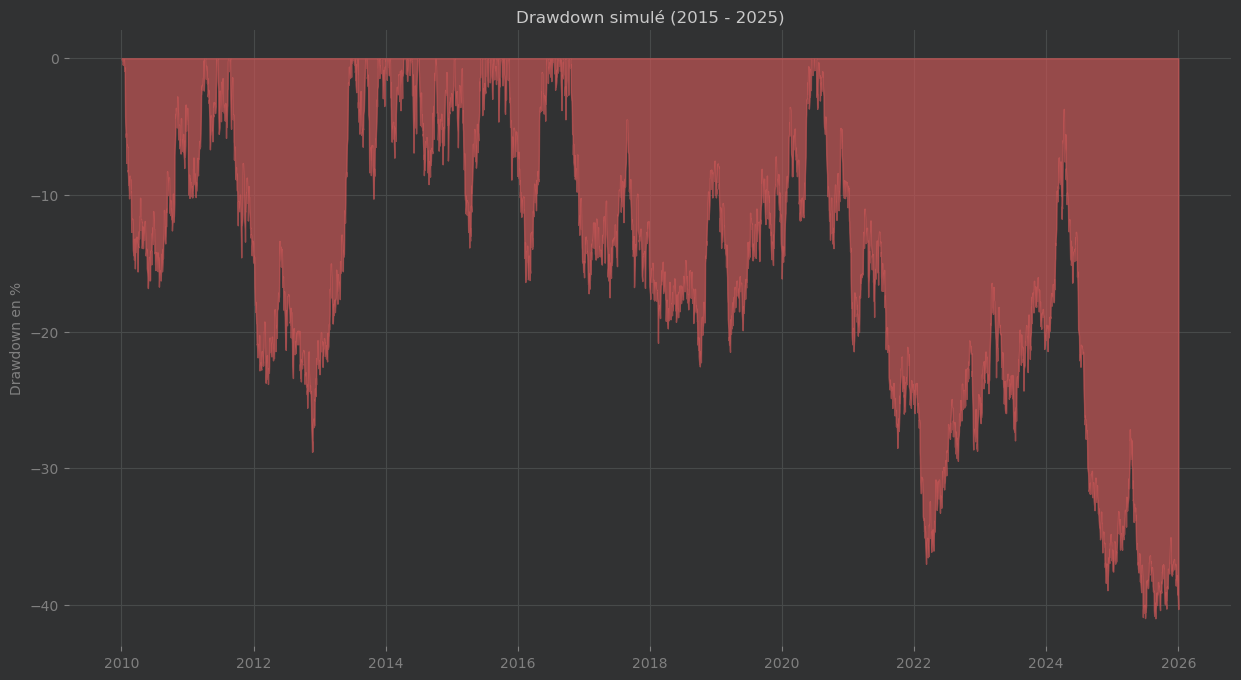

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def drawdown_function(returns: pd.Series) -> pd.Series:
    # On retire les NaN pour éviter les problèmes
    returns = returns.dropna()
    
    # On calcule les rendements cumulés
    cumulative = (1 + returns).cumprod()
    
    # On calcule le maximum cumulé
    running_max = cumulative.cummax()
    
    # Le drawdown = perte relative par rapport au maximum précédent
    drawdown = cumulative / running_max - 1
    
    return drawdown

# Génération de données fictives entre 2015 et 2025
np.random.seed(42)
dates = pd.date_range(start="2010-01-01", end="2026-01-01", freq="B")  # "B" = jours ouvrés
returns = pd.Series(np.random.normal(0, 0.01, size=len(dates)), index=dates)

# Calcul du drawdown
drawdown = drawdown_function(returns)

# Affichage
plt.figure(figsize=(15, 8))
plt.fill_between(drawdown.index, drawdown * 100, 0, color="#CE5757", alpha=0.65)
plt.title("Drawdown simulé (2015 - 2025)")
plt.ylabel("Drawdown en %")
plt.grid(True)
plt.show()


In [25]:
# Computation Max drawdown
max_drawdown = -np.min(drawdown)*100
print(f"Max drawdown: {'%.1f' % max_drawdown} %")

Max drawdown: 41.0 %


# Section 3: Create function BackTest to evaluate the strategy in the later sections

In [28]:
def BackTest(serie, annualiazed_scalar=252):

  # Import the benchmark
  sp500 = yf.download("^GSPC")["Close"].pct_change(1)
  
  # Change the name
  sp500.name = "SP500"

  # Concat the returns and the sp500
  val = pd.concat((serie,sp500), axis=1).dropna()
  # Compute the drawdown
  drawdown = drawdown_function(serie)*100
  
  # Compute max drawdown
  max_drawdown = -np.min(drawdown)




  # Put a subplots
  fig, (cum, dra) = plt.subplots(1,2, figsize=(20,6))
  
  # Put a Suptitle
  fig.suptitle("Backtesting", size=20)

  # Returns cumsum chart
  cum.plot(serie.cumsum()*100, color="#39B3C7")

  # SP500 cumsum chart
  cum.plot(val["SP500"].cumsum()*100, color="#B85A0F")

  # Put a legend
  cum.legend(["Portfolio", "SP500"])
  
  # Set individual title
  cum.set_title("Cumulative Return", size=13)

  cum.set_ylabel("Cumulative Return %", size=11)

  # Put the drawdown
  dra.fill_between(drawdown.index,0,drawdown, color="#C73954", alpha=0.65)

  # Set individual title
  dra.set_title("Drawdown", size=13)

  dra.set_ylabel("drawdown in %", size=11)

  # Plot the graph
  plt.show()


  # Compute the sortino
  sortino = np.sqrt(annualiazed_scalar) * serie.mean()/serie.loc[serie<0].std()

  # Compute the beta
  beta = np.cov(val[["return", "SP500"]].values,rowvar=False)[0][1] / np.var(val["SP500"].values)

  # Compute the alpha
  alpha = annualiazed_scalar * (serie.mean() - beta*serie.mean())

  # Print the statistics
  print(f"Sortino: {np.round(sortino,3)}")
  print(f"Beta: {np.round(beta,3)}")
  print(f"Alpha: {np.round(alpha*100,3)} %")
  print(f"MaxDrawdown: {np.round(max_drawdown,3)} %")

In [30]:
import yfinance as yf
import pandas as pd

# 1. Télécharger les données du S&P 500
sp500 = yf.download("^GSPC", start="2005-01-01", end="2019-01-01")

# 2. Sélectionner la colonne 'Close'
close_prices = sp500["Close"]

# 3. Calculer les variations en pourcentage (rendement journalier)
returns = close_prices.pct_change(1)

# 4. Concaténer les rendements et les prix de clôture dans un seul DataFrame
 val = pd.concat((serie,sp500), axis=1).dropna()





IndentationError: unexpected indent (283467336.py, line 14)

[*********************100%***********************]  1 of 1 completed


KeyError: 'SP500'

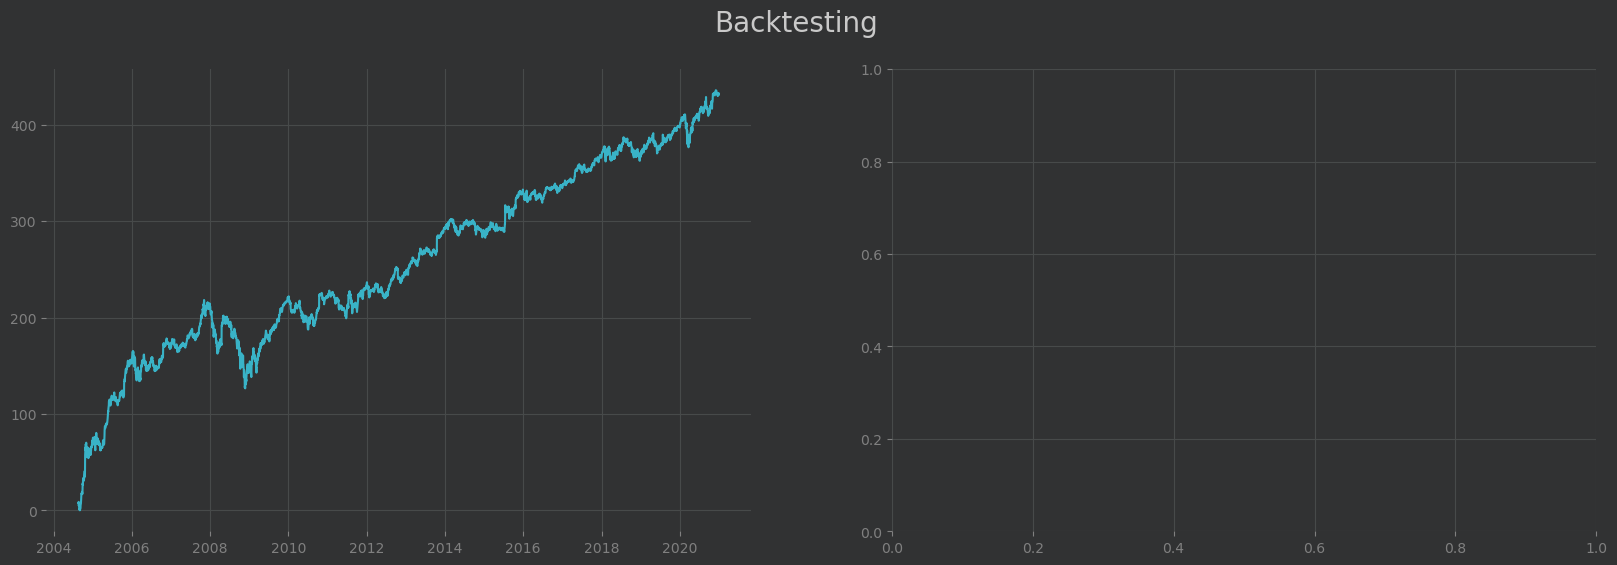

In [32]:
BackTest(return_serie, 252)

##### APPLICATION

In [ ]:
!pip install ta

In [ ]:
import ta
def lin_reg_trading(symbol):

  def feature_engineering(df):
    """ Create new variables"""
    
    # We copy the dataframe to avoid interferences in the data
    df_copy = df.dropna().copy()
    
    # Create the returns
    df_copy["returns"] = df_copy["close"].pct_change(1)

    # Create the SMAs
    df_copy["SMA 15"] = df_copy[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["close"]].rolling(60).mean().shift(1)
    
    # Create the volatilities
    df_copy["MSD 10"] = df_copy[["returns"]].rolling(10).std().shift(1)
    df_copy["MSD 30"] = df_copy[["returns"]].rolling(30).std().shift(1)
    
    # Create the Rsi
    RSI = ta.momentum.RSIIndicator(df_copy["close"], window= 14, fillna = False)
    df_copy["rsi"] = RSI.rsi()
    
    return df_copy.dropna()
  

  # Import the data
  df = yf.download(symbol)

  # Take adjusted close
  df = df[["Adj Close"]]

  # Rename the column
  df.columns = ["close"]

  dfc = feature_engineering(df)

  # Percentage train set
  split = int(0.80*len(dfc))

  # Train set creation
  X_train = dfc[['SMA 15', 'SMA 60', 'MSD 10', 'MSD 30', 'rsi']].iloc[:split]
  y_train = dfc[["returns"]].iloc[:split]


  # Test set creation
  X_test = dfc[['SMA 15', 'SMA 60', 'MSD 10', 'MSD 30', 'rsi']].iloc[split:]
  y_test = dfc[["returns"]].iloc[split:]

  # Import the class
  from sklearn.linear_model import LinearRegression

  # Initialize the class
  reg = LinearRegression()

  # Fit the model
  reg.fit(X_train, y_train)

  # Create predictions for the whole dataset
  X = np.concatenate((X_train, X_test), axis=0)

  dfc["prediction"] = reg.predict(X)

  # Compute the position
  dfc["position"] = np.sign(dfc["prediction"])

  # Compute the returns
  dfc["strategy"] = dfc["returns"] * dfc["position"].shift(1)

  dfc["return"] = dfc["strategy"]

  BackTest(dfc["return"].iloc[split:])

In [ ]:
lin_reg_trading("ETH-EUR")